# Torch Batteries Example: Image Classification with CNN

This notebook demonstrates how to use the `torch-batteries` library to train a Convolutional Neural Network (CNN) for image classification. We'll use the event-driven training approach with the `@charge` decorator to define training, validation, testing, and prediction steps. Additionally, we'll utilize Early Stopping and Model Checkpointing callbacks to enhance our training process.

## Overview
We'll be classifying images from the MNIST dataset using a simple CNN architecture with the Battery trainer class.

## 0. Installation
Install torch-batteries with necessary packages for this example:

In [1]:
%pip install torch-batteries[example]

/home/tosiek/Documents/IX_semestr/APP/torch-batteries/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


## 1. Setup and Dependencies
First, let's import the required libraries and check the versions of torch-batteries and PyTorch

In [2]:
import torch

import torch_batteries

print(f"torch-batteries version: {torch_batteries.__version__}")
print(f"PyTorch version: {torch.__version__}")

torch-batteries version: 0.4.1
PyTorch version: 2.9.1+cu128


## 2. Data Preparation
We'll use the MNIST dataset for image classification and split it into training, validation, and test set.

In [3]:
import torchvision

from torch.utils.data import DataLoader, random_split

BATCH_SIZE = 128
# Download and prepare MNIST dataset
mnist_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

# Split dataset into train/validation/test sets
train_size = int(0.7 * len(mnist_dataset))
val_size = int(0.15 * len(mnist_dataset))
test_size = len(mnist_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    mnist_dataset, [train_size, val_size, test_size]
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train samples: 42000
Validation samples: 9000
Test samples: 9000
Batch size: 128
Training batches: 329
Validation batches: 71
Test batches: 71


## 3. Model Definition and Training

Now we'll define a simple CNN model for image classification and set up the training process using the Battery trainer class. Additionally, we'll use Early Stopping to prevent overfitting and Model Checkpointing to save the best model during training.

### Key Features:
- **@charge(Event.TRAIN_STEP)**: Defines the forward pass and loss calculation for training
- **@charge(Event.VALIDATION_STEP)**: Defines validation logic
- **@charge(Event.TEST_STEP)**: Defines testing logic
- **@charge(Event.PREDICT_STEP)**: Defines prediction logic (forward pass only)

**Important**: Methods marked with the `@charge` decorator receive an `EventContext` parameter, which is a dictionary containing relevant information such as:
- `batch`: The current batch data
- `batch_idx`: Index of the current batch
- `epoch`: Current epoch number
- `optimizer`: The optimizer being used (for training events)
- `loss`: Computed loss value (for AFTER_* events)
- `train_metrics`, `val_metrics`, `test_metrics`: Computed metrics for each phase

You can access these fields as needed in your step methods using `context["field_name"]`.

In [4]:
from torch import nn
from torch.nn import functional as F  # noqa: N812

from torch_batteries import Event, charge
from torch_batteries.events import EventContext

class CNNClassifier(nn.Module):
    def __init__(self, input_channels=1, input_height=28, input_width=28, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * input_height // 4 * input_width // 4, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

    @charge(Event.TRAIN_STEP)
    def train_step(self, context: EventContext):
        batch = context["batch"]
        images, labels = batch
        outputs = self.forward(images)
        return F.cross_entropy(outputs, labels)

    @charge(Event.VALIDATION_STEP)
    def validation_step(self, context: EventContext):
        batch = context["batch"]
        images, labels = batch
        outputs = self.forward(images)
        return F.cross_entropy(outputs, labels)

    @charge(Event.TEST_STEP)
    def test_step(self, context: EventContext):
        batch = context["batch"]
        images, labels = batch
        outputs = self(images)
        return F.cross_entropy(outputs, labels)

    @charge(Event.PREDICT_STEP)
    def predict_step(self, context: EventContext):
        batch = context["batch"]
        images, _ = batch
        outputs = self(images)
        return torch.argmax(outputs, dim=1)


### Using custom metrics
Described in the `function_fitting.ipynb` example, you can define and use custom metrics during training, validation, and testing phases.

In [5]:
def accuracy_metric(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return (preds == labels).float().mean()

### Using Callbacks

#### Method 1. Using built-in callbacks
You can use built-in callbacks like Early Stopping and Model Checkpointing to enhance your training process.

#### Method 2. Using custom callbacks
You can also define your own custom callbacks by decorating methods with `@charge(Event.BEFORE_EPOCH)`, `@charge(Event.AFTER_EPOCH)`, etc.

#### Method 3. Combine both approaches
You can combine built-in and custom callbacks as needed for your training process. You just need to pass them to `Battery(callbacks=[...])`.


In [6]:
from torch_batteries import Battery
from torch_batteries.callbacks.early_stopping import EarlyStopping
from torch_batteries.callbacks.model_checkpoint import ModelCheckpoint

model = CNNClassifier(input_channels=1, input_height=28, input_width=28, num_classes=10)
early_stopping = EarlyStopping(stage="val", metric="acc", mode="max", patience=1)
model_checkpoint = ModelCheckpoint(save_path="{epoch}-{acc:.2f}", stage="val", metric="acc", mode="max", save_top_k=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

battery = Battery(
    model,
    optimizer=optimizer,
    metrics={"acc": accuracy_metric},
    callbacks=[early_stopping, model_checkpoint],
)

print("Starting training...")
train_results = battery.train(
    train_loader=train_loader, val_loader=val_loader, epochs=100
)

print("Training completed!")
print(f"Training loss: {train_results['train_loss'][-1]:.6f}")
print(f"Training accuracy: {train_results['train_metrics']['acc'][-1]:.6f}")
print(f"Validation loss: {train_results['val_loss'][-1]:.6f}")
print(f"Validation accuracy: {train_results['val_metrics']['acc'][-1]:.6f}")

Starting training...


Epoch 6/100 [Validation]: 100%|██████████| 71/71 [00:02<00:00, 23.81it/s, Loss=0.0528, Acc=0.9858]

Training completed!
Training loss: 0.024628
Training accuracy: 0.994429
Validation loss: 0.052814
Validation accuracy: 0.985778


## 4. Model Evaluation

Let's evaluate our trained model on the test set to see how well it generalizes to unseen data.

In [7]:
test_results = battery.test(test_loader)
print(f"Test Loss: {test_results['test_loss']:.6f}")
print(f"Test accuracy: {test_results['test_metrics']['acc']:.6f}")

Epoch 1/1 [Test]: 100%|██████████| 71/71 [00:02<00:00, 24.42it/s, Loss=0.0474, Acc=0.9872]

Test Loss: 0.047441
Test accuracy: 0.987222


## 5. Results Visualization

Finally, let's visualize the training progress and see how well our model learned to classify images.

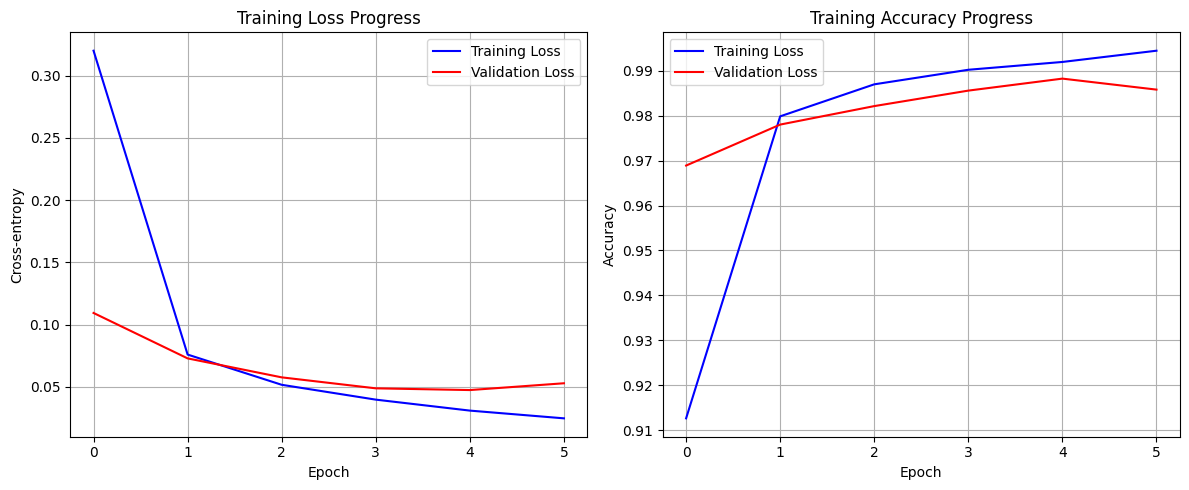

In [8]:
import matplotlib.pyplot as plt

# Plot loss progress
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_results["train_loss"], "b-", label="Training Loss")
plt.plot(train_results["val_loss"], "r-", label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy")
plt.title("Training Loss Progress")
plt.legend()
plt.grid()

# Plot accuracy progress
plt.subplot(1, 2, 2)
plt.plot(train_results['train_metrics']['acc'], "b-", label="Training Loss")
plt.plot(train_results['val_metrics']['acc'], "r-", label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Progress")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

Epoch 1/1 [Predict]: 100%|██████████| 13/13 [00:00<00:00, 435.26it/s]


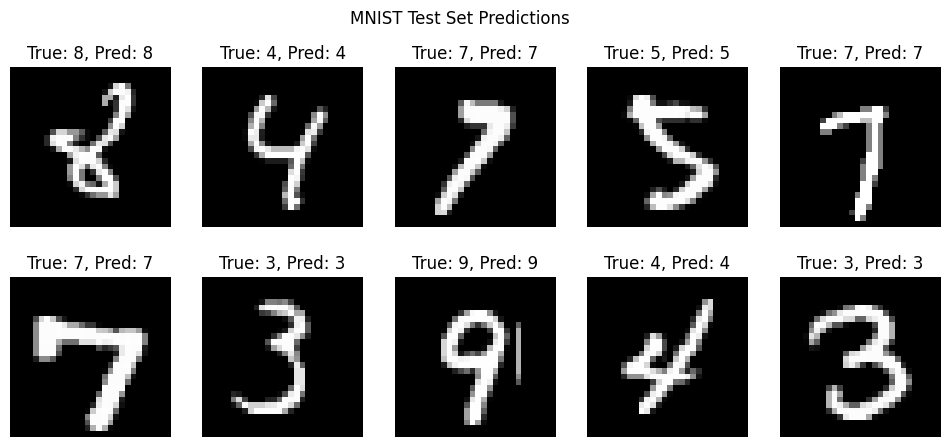

In [9]:
# Visualize prediction on the first 10 images from the test set
test_iter = iter(test_loader)
images, labels = next(test_iter)
predictions = battery.predict(DataLoader(torch.utils.data.TensorDataset(images, labels), batch_size=10))["predictions"]
preds = torch.cat(predictions, dim=0).cpu().numpy()
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(images[i].squeeze(), cmap="gray")
    ax.set_title(f"True: {labels[i].item()}, Pred: {preds[i]}")
    ax.axis("off")
plt.suptitle("MNIST Test Set Predictions")
plt.show()